In [8]:
from amalearn.reward import GaussianReward, RewardBase
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
import numpy as np
from math import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import gym
import timeit

In [10]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,73,74]
      no_down = lambda s: s in [23,24,54]
      no_left = lambda s: s in [44,35,54,65]
      no_right = lambda s: s in [32,42,52,62]

      #Barries in the path
      pit = lambda s: s in [13,72,41]
      wall = lambda s: s in [43,33,53,34,64,63]

      #Rewards of each state
      reward = 15.0 if is_done(s) else -1.0
      reward = -15.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -5.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -5.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -5.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -5.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,72,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,72,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,64,63]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

In [11]:
class Agent_On_MC(AgentBase):
    def __init__(self, id, environment, action_count, state_count, epsilon):
        super(Agent_On_MC, self).__init__(id, environment)
        self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.returns_sa = [[ [] for i in range(action_count)] for j in range(state_count)]
        self.action_count = action_count
        self.state_count = state_count
        self.epsilon = epsilon
        self.env = environment
        self.R_avg = []
        self.R_sum = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
    
    def generate(self):
        init_s = np.random.choice([i for i in range(self.state_count)])
        ep = []
        action = self.policy[init_s]
        state_p = init_s
        R = []
        flag = False
        while True:
            #state, reward, done, info = self.env.step(action)
            _, state, reward, done = self.env.P[state_p][action][0]
            ep.append([state_p,action,reward])
            if len(ep) > 20000:
                break
            if done:
                if flag:
                    break
                else:
                    flag = True
            action = self.policy[state]
            state_p = state
            p = random.random()
            R.append(reward)
            if p< 1-self.epsilon:
                action = self.policy[state]
            else:
                action = np.random.choice([i for i in range(self.action_count)])
        #print("episode length:"+str(len(ep))+" with mean reward of: "+str(np.mean(R)))
        self.R_avg.append(np.mean(R))
        self.R_sum.append(np.sum(R))
        return ep
        
    def main_loop(self):
        for k in range(1000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            #print(k)
            policy_p = self.policy
            ep = self.generate()
            G = 0
            T = [len(ep)-1-i for i in range(len(ep)-1)]
            for t in T:
                G = G + ep[t][2]
                flag = False
                for x in ep[0:t+1][0:2]:
                    if x[0] == ep[t][0] and x[1] == ep[t][1]:
                        flag = True
                        break
                if not flag:
                    self.returns_sa[ep[t][0]][ep[t][1]].append(G)
                    self.Q_sa[ep[t][1]][ep[t][0]] = np.mean(self.returns_sa[ep[t][0]][ep[t][1]])
                    A_star = np.argmax([self.Q_sa[i][ep[t][0]] for i in range(self.action_count)])
                    self.policy[ep[t][0]] = A_star
                    '''p = random.random()
                    if p< 1-self.epsilon:
                        self.policy[ep[t][0]] = ep[t][1]
                    else:
                        self.policy[ep[t][0]] = np.random.choice([i for i in range(self.action_count)])
            '''
                
    
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = 0
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #self.environment.update_selected_arm(index_selected_arm, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

constatnt time = 0.00024493799719493836
dynamic time = 75.05570763199648


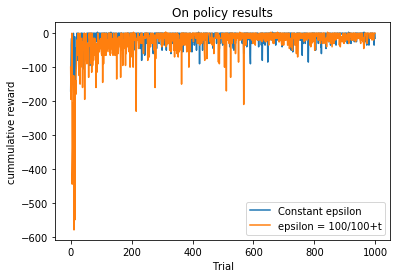

In [123]:
env =  GridworldEnv()
env.reset()
#env._render()
t = timeit.default_timer()
agent_on = Agent_On_MC('1', env, 4,100,0.5)
t1_on = timeit.default_timer() - t
print("constatnt time = "+str(t1_on))
agent_on.main_loop()
plt.plot([i for i in range(1000)],agent_on.R_sum, label = "Constant epsilon")
agent_on2 = Agent_On_MC('1', env, 4,100,0)
t = timeit.default_timer()
agent_on2.main_loop()
t2_on = timeit.default_timer() - t
print("dynamic time = "+str(t2_on))
plt.plot([i for i in range(1000)],agent_on2.R_sum, label = "epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("On policy results")
plt.legend()
plt.show()

In [12]:
class Agent_Off_MC(AgentBase):
    def __init__(self, id, environment, action_count, state_count, epsilon):
        super(Agent_Off_MC, self).__init__(id, environment)
        self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.C_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.env = environment
        self.R_avg = []
        self.R_sum = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
    
    def generate(self, b):
        init_s = np.random.choice([i for i in range(self.state_count)])
        ep = []
        action = self.policy[init_s]
        state_p = init_s
        R = []
        flag = False
        while True:
            #state, reward, done, info = self.env.step(action)
            _, state, reward, done = self.env.P[state_p][action][0]
            ep.append([state_p,action,reward])
            if len(ep)>20000:
                break
            if done:
                if flag:
                    break
                else:
                    flag = True
            action = self.policy[state]
            state_p = state
            p = random.random()
            R.append(reward)
            if p< 1-self.epsilon:
                action = b[state]
            else:
                action = np.random.choice([i for i in range(self.action_count)])
        #print("episode length:"+str(len(ep))+" with mean reward of: "+str(np.mean(R)))
        self.R_avg.append(np.mean(R))
        self.R_sum.append(np.sum(R))
        return ep
        
    def main_loop(self):
        gama = 0.9
        for k in range(1000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            b = [np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            ep = self.generate(b)
            G = 0
            W = 1
            T = [len(ep)-1-i for i in range(len(ep)-1)]
            for t in T:
                G = gama * G + ep[t][2]
                self.C_sa[ep[t][1]][ep[t][0]] = self.C_sa[ep[t][1]][ep[t][0]] + W
                self.Q_sa[ep[t][1]][ep[t][0]] = self.Q_sa[ep[t][1]][ep[t][0]] + W/self.C_sa[ep[t][1]][ep[t][0]]*(G-self.Q_sa[ep[t][1]][ep[t][0]])
                A_star = np.argmax([self.Q_sa[i][ep[t][0]] for i in range(self.action_count)])
                self.policy[ep[t][0]] = A_star
                if ep[t][1] != A_star:
                    break
                if ep[t][1] == b[ep[t][0]]:
                    W = W/(1-self.epsilon+self.epsilon/self.action_count)
                else:
                    W = W/(self.epsilon/self.action_count)
                
    
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = 0
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #self.environment.update_selected_arm(index_selected_arm, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

constatnt time = 0.00024493799719493836
dynamic time = 75.05570763199648


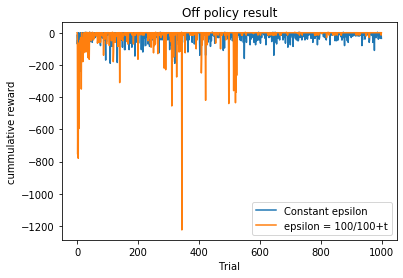

In [125]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_of = Agent_Off_MC('2', env, 4,100,0.5)
t = timeit.default_timer()
agent_of.main_loop()
t1_of = timeit.default_timer() - t
plt.plot([i for i in range(1000)],agent_of.R_sum,label="Constant epsilon")
agent_of2 = Agent_Off_MC('2', env, 4,100,0)
t = timeit.default_timer()
agent_of2.main_loop()
t2_of = timeit.default_timer() - t
print("constatnt time = "+str(t1_on))
print("dynamic time = "+str(t2_on))
plt.plot([i for i in range(1000)],agent_of2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Off policy result")
plt.legend()
plt.show()

In [13]:
class Agent_SARSA(AgentBase):
    def __init__(self, id, environment, action_count, state_count, alpha, epsilon):
        super(Agent_SARSA, self).__init__(id, environment)
        self.alpha = alpha
        self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.env = environment
        self.R_avg = []
        self.R_sum = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
    
    def main_loop(self):
        gama = 0.9
        for k in range(1000):
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state = np.random.choice([i for i in range(self.state_count)])
            p = random.random()
            R = []
            #[np.argmax([self.Q_sa[i][j] for i in range(self.action_count)]) for j in range(self.state_count)]
            if p< 1-self.epsilon:
                action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
            else:
                action = np.random.choice([i for i in range(self.action_count)])
            flag = False
            length = 0
            while True:
                length = length + 1
                if length > 20000:
                    break
                _, state_p, reward, done = self.env.P[state][action][0]
                R.append(reward)
                p = random.random()
                if p< 1-self.epsilon:
                    action_p = np.argmax([self.Q_sa[i][state_p] for i in range(self.action_count)])
                else:
                    action_p = np.random.choice([i for i in range(self.action_count)])
                self.Q_sa[action][state] = self.Q_sa[action][state] + self.alpha*(reward+gama*self.Q_sa[action_p][state_p]- self.Q_sa[action][state])
                state = state_p
                action = action_p
                if done:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg.append(np.mean(R))
            self.R_sum.append(np.sum(R))
    
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = 0
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #self.environment.update_selected_arm(index_selected_arm, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

constatnt time = 8.60210148999613
dynamic time = 158.72152425799868


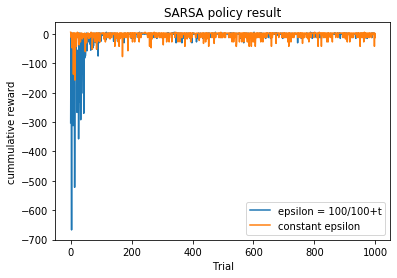

In [126]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_sarsa = Agent_SARSA('3', env, 4,100,0,0.5)
t = timeit.default_timer()
agent_sarsa.main_loop()
t1_sarsa = timeit.default_timer() - t
print("constatnt time = "+str(t1_sarsa))
agent_sarsa2 = Agent_SARSA('3', env, 4,100,0,0)
t = timeit.default_timer()
agent_sarsa2.main_loop()
t2_sarsa = timeit.default_timer() - t
print("dynamic time = "+str(t2_sarsa))
plt.plot([i for i in range(1000)],agent_sarsa2.R_sum, label="epsilon = 100/100+t")
plt.plot([i for i in range(1000)],agent_sarsa.R_sum, label="constant epsilon")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("SARSA policy result")
plt.legend()
plt.show()

In [14]:
class Agent_xpSARSA_2s(AgentBase):
    def __init__(self, id, environment, action_count, state_count, alpha, epsilon):
        super(Agent_xpSARSA_2s, self).__init__(id, environment)
        self.alpha = alpha
        #self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.epsilon = epsilon
        self.env = environment
        self.R_avg = []
        self.R_sum = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
    
    def main_loop(self):
        gama = 0.9
        for k in range(1000):
            if k%100 == 0:
                print(k)
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state = np.random.choice([i for i in range(self.state_count)])
            p = random.random()
            if p< 1-self.epsilon:
                action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
            else:
                action = np.random.choice([i for i in range(self.action_count)])
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            flag = False
            R = []
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                _, state_p, reward, done = self.env.P[state][action][0]
                R.append(reward)
                if done:
                    if flag:
                        break
                    else:
                        flag = True
                p = random.random()
                if p< 1-self.epsilon:
                    action_p = np.argmax([self.Q_sa[i][state_p] for i in range(self.action_count)])
                else:
                    action_p = np.random.choice([i for i in range(self.action_count)])
                _, state_p2, reward2, donep = self.env.P[state_p][action_p][0]
                R.append(reward2)
                sum_Q = np.sum([self.Q_sa[i][state_p2] for i in range(self.action_count)])
                sum_Q = sum_Q*self.epsilon/self.action_count + (1-self.epsilon)*np.max([self.Q_sa[i][state_p2] for i in range(self.action_count)])
                self.Q_sa[action][state] = self.Q_sa[action][state] + self.alpha*(reward+gama*reward2+ gama*gama*(sum_Q)- self.Q_sa[action][state])
                state = state_p2
                p = random.random()
                if p< 1-self.epsilon:
                    action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
                else:
                    action = np.random.choice([i for i in range(self.action_count)])

                '''if donep:
                    if flag:
                        break
                    else:
                        flag = True'''
            self.R_avg.append(np.mean(R))
            self.R_sum.append(np.sum(R))
    
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = 0
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #self.environment.update_selected_arm(index_selected_arm, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
dynamic time = 60.043986946002406
constatnt time = 14.844310184998903


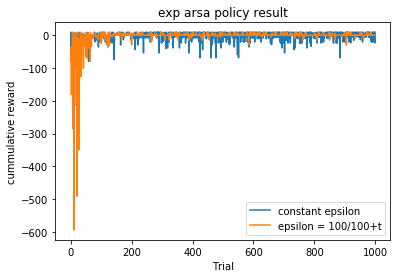

In [127]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_sarsa_2xp = Agent_xpSARSA_2s('4', env, 4,100,0,0.5)
t = timeit.default_timer()
agent_sarsa_2xp.main_loop()
t1_sarsa2xp = timeit.default_timer() - t
agent_sarsa_2xp2 = Agent_xpSARSA_2s('4', env, 4,100,0,0)
t = timeit.default_timer()
agent_sarsa_2xp2.main_loop()
t2_sarsa2xp = timeit.default_timer() - t
print("dynamic time = "+str(t2_sarsa2xp))

print("constatnt time = "+str(t1_sarsa2xp))
plt.plot([i for i in range(1000)],agent_sarsa_2xp.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent_sarsa_2xp2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("exp arsa policy result")
plt.legend()
plt.show()

In [15]:
class Agent_DQlearning(AgentBase):
    def __init__(self, id, environment, action_count, state_count, alpha, epsilon):
        super(Agent_DQlearning, self).__init__(id, environment)
        self.alpha = alpha
        #self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.QA_sa = np.zeros((action_count,state_count))
        self.QB_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.epsilon = epsilon
        self.env = environment
        self.R_avg = []
        self.R_sum = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
    
    def main_loop(self):
        gama = 0.9
        for k in range(1000):
            #if k%10 == 0:
            #    print(k)
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state = np.random.choice([i for i in range(self.state_count)])
            flag = False
            R = []
            length = 0
            while True:
                length = length + 1
                if length>20000:
                    break
                p = random.random()
                #select action
                if p< 1-self.epsilon:
                    action = np.argmax([self.QA_sa[i][state]+self.QB_sa[i][state] for i in range(self.action_count)])
                else:
                    action = np.random.choice([i for i in range(self.action_count)])
                _, state_p, reward, done = self.env.P[state][action][0]
                R.append(reward)
                p = random.random()
                if p<0.5:
                    A_star = np.argmax([self.QA_sa[i][state_p] for i in range(self.action_count)])
                    self.QA_sa[action][state] = self.QA_sa[action][state] + self.alpha*(reward+gama*self.QB_sa[A_star][state_p] - self.QA_sa[action][state] )
                else:
                    A_star = np.argmax([self.QB_sa[i][state_p] for i in range(self.action_count)])
                    self.QB_sa[action][state] = self.QB_sa[action][state] + self.alpha*(reward+gama*self.QA_sa[A_star][state_p] - self.QB_sa[action][state] )
                state = state_p    
                if done:
                    if flag:
                        break
                    else:
                        flag = True
            self.R_avg.append(np.mean(R))
            self.R_sum.append(np.sum(R))
                
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = 0
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #self.environment.update_selected_arm(index_selected_arm, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

constatnt time = 0.5003012350061908
dynamic time = 0.4708940359996632


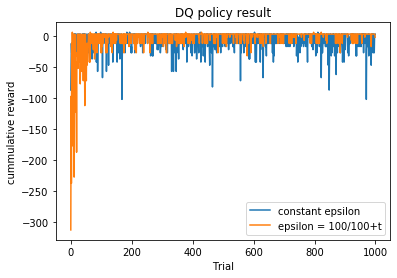

In [128]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_DQ = Agent_DQlearning('5', env, 4,100,0,0.5)
t = timeit.default_timer()
agent_DQ.main_loop()
t1_DQ = timeit.default_timer() - t
print("constatnt time = "+str(t1_DQ))
agent_DQ2 = Agent_DQlearning('5', env, 4,100,0,0)
t = timeit.default_timer()
agent_DQ2.main_loop()
t2_DQ = timeit.default_timer() - t
print("dynamic time = "+str(t2_DQ))
plt.plot([i for i in range(1000)],agent_DQ.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent_DQ2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("DQ policy result")
plt.legend()
plt.show()

In [16]:
class Agent_Nstep_Tr(AgentBase):
    def __init__(self, id, environment, action_count, state_count, alpha, epsilon, N):
        super(Agent_Nstep_Tr, self).__init__(id, environment)
        self.alpha = alpha
        #self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.N = N
        self.Q_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.epsilon = epsilon
        self.env = environment
        self.R_avg = []
        self.R_sum = []
        self.R = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
    
    def G_value(self,t,tn,R,gama, state):
        if t == tn:
            sum_Q = np.sum([self.Q_sa[i][state] for i in range(self.action_count)])
            sum_Q = sum_Q*self.epsilon/self.action_count + (1-self.epsilon)*np.max([self.Q_sa[i][state] for i in range(self.action_count)])
            return sum_Q
        t = t+1
        action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
        _, state_p, reward, done = self.env.P[state][action][0]
        if done:
            sum_Q = np.sum([self.Q_sa[i][state] for i in range(self.action_count)])
            sum_Q = sum_Q*self.epsilon/self.action_count + (1-self.epsilon)*np.max([self.Q_sa[i][state] for i in range(self.action_count)])
            return R + gama*sum_Q*(1+self.epsilon/self.action_count-self.epsilon) +gama*(np.sum([self.Q_sa[i][state_p] for i in range(self.action_count)])-np.max([self.Q_sa[i][state_p] for i in range(self.action_count)]))
        self.R.append(reward)
        return R + gama*self.G_value(t,tn,reward,gama,state_p)*(1+self.epsilon/self.action_count-self.epsilon) +gama*(np.sum([self.Q_sa[i][state_p] for i in range(self.action_count)])-np.max([self.Q_sa[i][state_p] for i in range(self.action_count)]))
    
    def main_loop(self):
        gama = 0.9
        for k in range(1000):
            #if k%100 == 0:
            #    print(k)
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            state = np.random.choice([i for i in range(self.state_count)])
            p = random.random()
            if p< 1-self.epsilon:
                action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
            else:
                action = np.random.choice([i for i in range(self.action_count)])
            flag = False
            self.R = []
            length = 0
            while True:
                length = length + 1
                if length>20000:
                    break
                _, state_p, reward, done = self.env.P[state][action][0]
                self.R.append(reward)
                self.Q_sa[action][state] = self.Q_sa[action][state] + self.alpha*(self.G_value(1,self.N,reward,gama,state_p) - self.Q_sa[action][state])
                if done:
                    if flag:
                        break
                    else:
                        flag = True
                for i in range(self.N):
                    state = state_p
                    p = random.random()
                    if p< 1-self.epsilon:
                        action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
                    else:
                        action = np.random.choice([i for i in range(self.action_count)])
                    _, state_p, reward, done = self.env.P[state][action][0]
                    if done:
                        if flag:
                            break
                        else:
                            flag = True
                state = state_p
                if p< 1-self.epsilon:
                    action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
                else:
                    action = np.random.choice([i for i in range(self.action_count)])
            self.R_avg.append(np.mean(self.R))
            self.R_sum.append(np.sum(self.R))
    
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = 0
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #self.environment.update_selected_arm(index_selected_arm, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

constatnt time = 1.5500031410047086
dynamic time = 1.6857253589987522


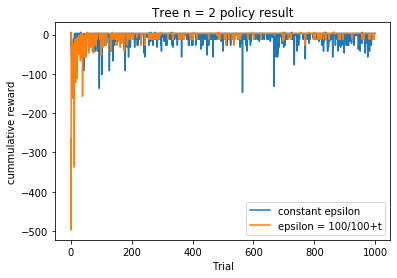

constatnt time = 2.834128658003465
dynamic time = 1.4028099150018534


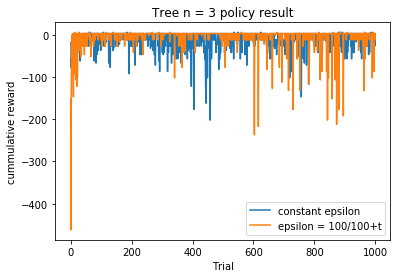

constatnt time = 2.0135051800025394
dynamic time = 1.4930945209998754


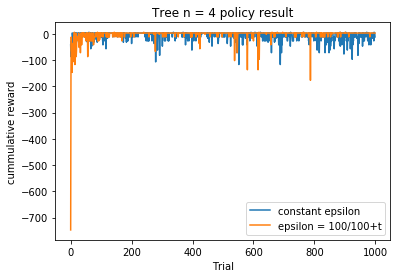

In [129]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_Tr = Agent_Nstep_Tr('6', env, 4,100,0.1,0.5,2)
t = timeit.default_timer()
agent_Tr.main_loop()
t1_Tr = timeit.default_timer() - t
print("constatnt time = "+str(t1_Tr))
agent_Tr2 = Agent_Nstep_Tr('6', env, 4,100,0.1,0,2)
t = timeit.default_timer()
agent_Tr2.main_loop()
t2_Tr = timeit.default_timer() - t
print("dynamic time = "+str(t2_Tr))
plt.plot([i for i in range(1000)],agent_Tr.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent_Tr2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Tree n = 2 policy result")
plt.legend()
plt.show()
env =  GridworldEnv()
env.reset()
#print(env.P)
agent3_Tr = Agent_Nstep_Tr('6', env, 4,100,0.1,0.5,3)
t = timeit.default_timer()
agent3_Tr.main_loop()
t1_Tr3 = timeit.default_timer() - t
print("constatnt time = "+str(t1_Tr3))
agent3_Tr2 = Agent_Nstep_Tr('6', env, 4,100,0.1,0,3)
t = timeit.default_timer()
agent3_Tr2.main_loop()
t2_Tr3 = timeit.default_timer() - t
print("dynamic time = "+str(t2_Tr3))
plt.plot([i for i in range(1000)],agent3_Tr.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent3_Tr2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Tree n = 3 policy result")
plt.legend()
plt.show()

env =  GridworldEnv()
env.reset()
#print(env.P)
agent4_Tr = Agent_Nstep_Tr('6', env, 4,100,0.1,0.5,4)
t = timeit.default_timer()
agent4_Tr.main_loop()
t1_Tr4 = timeit.default_timer() - t
print("constatnt time = "+str(t1_Tr4))
agent4_Tr2 = Agent_Nstep_Tr('6', env, 4,100,0.1,0,4)
t = timeit.default_timer()
agent4_Tr2.main_loop()
t2_Tr4 = timeit.default_timer() - t
print("dynamic time = "+str(t2_Tr4))
plt.plot([i for i in range(1000)],agent4_Tr.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent4_Tr2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Tree n = 4 policy result")
plt.legend()
plt.show()

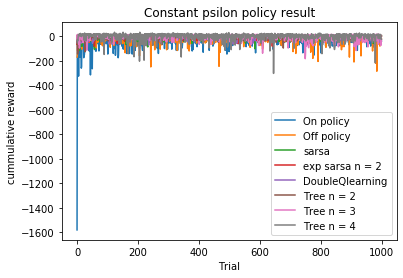

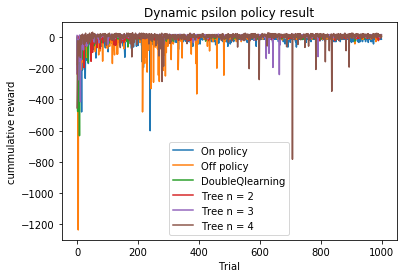

In [76]:

plt.plot([i for i in range(1000)],agent_on.R_sum, label = "On policy")
plt.plot([i for i in range(1000)],agent_of.R_sum,label="Off policy")
plt.plot([i for i in range(1000)],agent_sarsa.R_sum[0:1000], label="sarsa")
plt.plot([i for i in range(1000)],agent_sarsa_2xp.R_sum, label="exp sarsa n = 2")
plt.plot([i for i in range(1000)],agent_DQ.R_sum, label="DoubleQlearning")
plt.plot([i for i in range(1000)],agent_Tr.R_sum, label="Tree n = 2")
plt.plot([i for i in range(1000)],agent3_Tr.R_sum, label="Tree n = 3")
plt.plot([i for i in range(1000)],agent4_Tr.R_sum, label="Tree n = 4")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Constant psilon policy result")
plt.legend()
plt.show()


plt.plot([i for i in range(1000)],agent_on2.R_sum, label = "On policy")
plt.plot([i for i in range(1000)],agent_of2.R_sum, label="Off policy")
plt.plot([i for i in range(1000)],agent_DQ2.R_sum, label="DoubleQlearning")
plt.plot([i for i in range(1000)],agent_Tr2.R_sum, label="Tree n = 2")
plt.plot([i for i in range(1000)],agent3_Tr2.R_sum, label="Tree n = 3")
plt.plot([i for i in range(1000)],agent4_Tr2.R_sum, label="Tree n = 4")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Dynamic psilon policy result")
plt.legend()
plt.show()

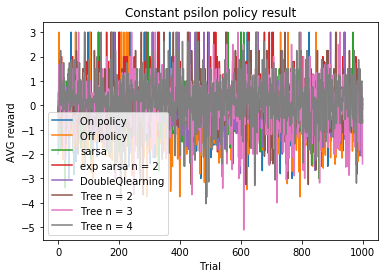

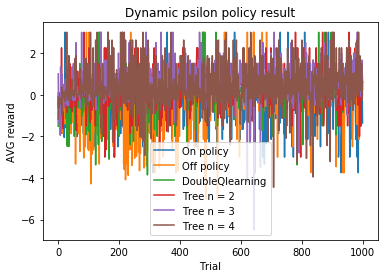

In [77]:

plt.plot([i for i in range(1000)],agent_on.R_avg, label = "On policy")
plt.plot([i for i in range(1000)],agent_of.R_avg,label="Off policy")
plt.plot([i for i in range(1000)],agent_sarsa.R_avg[0:1000], label="sarsa")
plt.plot([i for i in range(1000)],agent_sarsa_2xp.R_avg, label="exp sarsa n = 2")
plt.plot([i for i in range(1000)],agent_DQ.R_avg, label="DoubleQlearning")
plt.plot([i for i in range(1000)],agent_Tr.R_avg, label="Tree n = 2")
plt.plot([i for i in range(1000)],agent3_Tr.R_avg, label="Tree n = 3")
plt.plot([i for i in range(1000)],agent4_Tr.R_avg, label="Tree n = 4")
plt.xlabel("Trial")
plt.ylabel("AVG reward")
plt.title("Constant psilon policy result")
plt.legend()
plt.show()


plt.plot([i for i in range(1000)],agent_on2.R_avg, label = "On policy")
plt.plot([i for i in range(1000)],agent_of2.R_avg, label="Off policy")
plt.plot([i for i in range(1000)],agent_DQ2.R_avg, label="DoubleQlearning")
plt.plot([i for i in range(1000)],agent_Tr2.R_avg, label="Tree n = 2")
plt.plot([i for i in range(1000)],agent3_Tr2.R_avg, label="Tree n = 3")
plt.plot([i for i in range(1000)],agent4_Tr2.R_avg, label="Tree n = 4")
plt.xlabel("Trial")
plt.ylabel("AVG reward")
plt.title("Dynamic psilon policy result")
plt.legend()
plt.show()

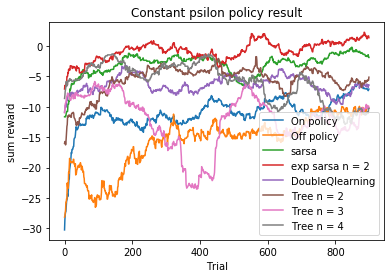

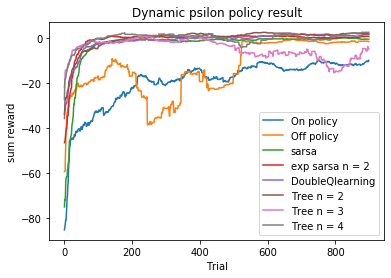

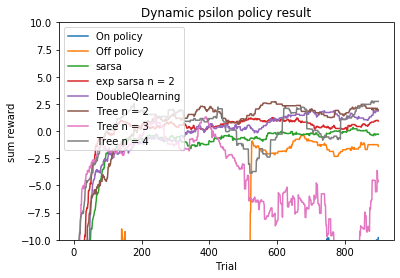

In [162]:
plt.plot([i for i in range(900)],[np.mean(agent_on.R_sum[i:i+ 100]) for i in range(900)], label = "On policy")
plt.plot([i for i in range(900)],[np.mean(agent_of.R_sum[i:i+ 100]) for i in range(900)],label="Off policy")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa.R_sum[i:i+ 100]) for i in range(900)], label="sarsa")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa_2xp.R_sum[i:i+ 100]) for i in range(900)], label="exp sarsa n = 2")
plt.plot([i for i in range(900)],[np.mean(agent_DQ.R_sum[i:i+ 100]) for i in range(900)], label="DoubleQlearning")
plt.plot([i for i in range(900)],[np.mean(agent_Tr.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 2")
plt.plot([i for i in range(900)],[np.mean(agent3_Tr.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 3")
plt.plot([i for i in range(900)],[np.mean(agent4_Tr.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 4")
plt.xlabel("Trial")
plt.ylabel("sum reward")
plt.title("Constant psilon policy result")
plt.legend()
plt.show()


plt.plot([i for i in range(900)],[np.mean(agent_on2.R_sum[i:i+ 100]) for i in range(900)], label = "On policy")
plt.plot([i for i in range(900)],[np.mean(agent_of2.R_sum[i:i+ 100]) for i in range(900)],label="Off policy")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa2.R_sum[i:i+ 100]) for i in range(900)], label="sarsa")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa_2xp2.R_sum[i:i+ 100]) for i in range(900)], label="exp sarsa n = 2")
plt.plot([i for i in range(900)],[np.mean(agent_DQ2.R_sum[i:i+ 100]) for i in range(900)], label="DoubleQlearning")
plt.plot([i for i in range(900)],[np.mean(agent_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 2")
plt.plot([i for i in range(900)],[np.mean(agent3_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 3")
plt.plot([i for i in range(900)],[np.mean(agent4_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 4")

plt.xlabel("Trial")
plt.ylabel("sum reward")
plt.title("Dynamic psilon policy result")
plt.legend()
plt.show()



plt.plot([i for i in range(900)],[np.mean(agent_on2.R_sum[i:i+ 100]) for i in range(900)], label = "On policy")
plt.plot([i for i in range(900)],[np.mean(agent_of2.R_sum[i:i+ 100]) for i in range(900)],label="Off policy")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa2.R_sum[i:i+ 100]) for i in range(900)], label="sarsa")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa_2xp2.R_sum[i:i+ 100]) for i in range(900)], label="exp sarsa n = 2")
plt.plot([i for i in range(900)],[np.mean(agent_DQ2.R_sum[i:i+ 100]) for i in range(900)], label="DoubleQlearning")
plt.plot([i for i in range(900)],[np.mean(agent_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 2")
plt.plot([i for i in range(900)],[np.mean(agent3_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 3")
plt.plot([i for i in range(900)],[np.mean(agent4_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 4")

plt.xlabel("Trial")
plt.ylabel("sum reward")
plt.title("Dynamic psilon policy result")
plt.ylim(-10,10)
plt.legend()
plt.show()

constatnt time = 0.0008106660000066768
dynamic time = 4.113027511000155


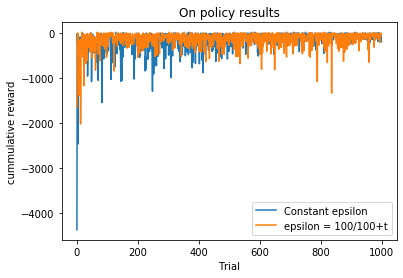

In [20]:
env =  GridworldEnv()
env.reset()
t = timeit.default_timer()
agent_on = Agent_On_MC('1', env, 4,100,0.5)
t1_on = timeit.default_timer() - t
agent_on.main_loop()
agent_on2 = Agent_On_MC('1', env, 4,100,0)
t = timeit.default_timer()
agent_on2.main_loop()
t2_on = timeit.default_timer() - t
print("constatnt time = "+str(t1_on))
print("dynamic time = "+str(t2_on))
plt.plot([i for i in range(1000)],agent_on.R_sum, label = "Constant epsilon")
plt.plot([i for i in range(1000)],agent_on2.R_sum, label = "epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("On policy results")
plt.legend()
plt.show()

constatnt time = 0.0008106660000066768
dynamic time = 4.113027511000155


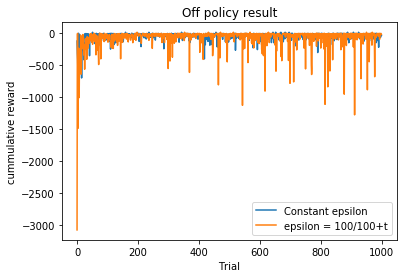

In [44]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_of = Agent_Off_MC('2', env, 4,100,0.5)
t = timeit.default_timer()
agent_of.main_loop()
t1_of = timeit.default_timer() - t
plt.plot([i for i in range(1000)],agent_of.R_sum,label="Constant epsilon")
agent_of2 = Agent_Off_MC('2', env, 4,100,0)
t = timeit.default_timer()
agent_of2.main_loop()
t2_of = timeit.default_timer() - t
print("constatnt time = "+str(t1_on))
print("dynamic time = "+str(t2_on))
plt.plot([i for i in range(1000)],agent_of2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Off policy result")
plt.legend()
plt.show()

constatnt time = 0.4354996800000208
dynamic time = 0.42317849899995963


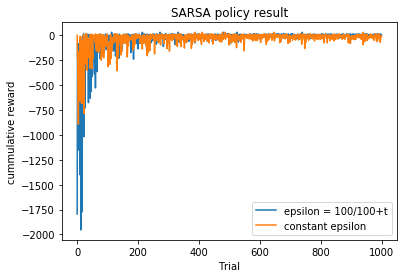

In [24]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_sarsa = Agent_SARSA('3', env, 4,100,0,0.5)
t = timeit.default_timer()
agent_sarsa.main_loop()
t1_sarsa = timeit.default_timer() - t
print("constatnt time = "+str(t1_sarsa))
agent_sarsa2 = Agent_SARSA('3', env, 4,100,0,0)
t = timeit.default_timer()
agent_sarsa2.main_loop()
t2_sarsa = timeit.default_timer() - t
print("dynamic time = "+str(t2_sarsa))
plt.plot([i for i in range(1000)],agent_sarsa2.R_sum, label="epsilon = 100/100+t")
plt.plot([i for i in range(1000)],agent_sarsa.R_sum, label="constant epsilon")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("SARSA policy result")
plt.legend()
plt.show()

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
dynamic time = 1.0086897749999935
constatnt time = 0.9026335199998812


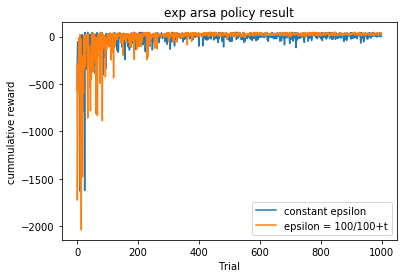

In [25]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_sarsa_2xp = Agent_xpSARSA_2s('4', env, 4,100,0,0.5)
t = timeit.default_timer()
agent_sarsa_2xp.main_loop()
t1_sarsa2xp = timeit.default_timer() - t
agent_sarsa_2xp2 = Agent_xpSARSA_2s('4', env, 4,100,0,0)
t = timeit.default_timer()
agent_sarsa_2xp2.main_loop()
t2_sarsa2xp = timeit.default_timer() - t
print("dynamic time = "+str(t2_sarsa2xp))

print("constatnt time = "+str(t1_sarsa2xp))
plt.plot([i for i in range(1000)],agent_sarsa_2xp.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent_sarsa_2xp2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("exp arsa policy result")
plt.legend()
plt.show()

constatnt time = 0.7787477420001778
dynamic time = 0.750193875999912


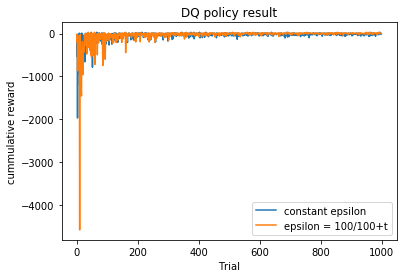

In [26]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_DQ = Agent_DQlearning('5', env, 4,100,0,0.5)
t = timeit.default_timer()
agent_DQ.main_loop()
t1_DQ = timeit.default_timer() - t
print("constatnt time = "+str(t1_DQ))
agent_DQ2 = Agent_DQlearning('5', env, 4,100,0,0)
t = timeit.default_timer()
agent_DQ2.main_loop()
t2_DQ = timeit.default_timer() - t
print("dynamic time = "+str(t2_DQ))
plt.plot([i for i in range(1000)],agent_DQ.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent_DQ2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("DQ policy result")
plt.legend()
plt.show()

constatnt time = 0.9883456840000235
dynamic time = 0.9691958640000848


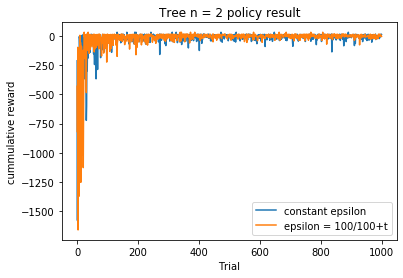

constatnt time = 0.9901013379999313
dynamic time = 1.0721698480001578


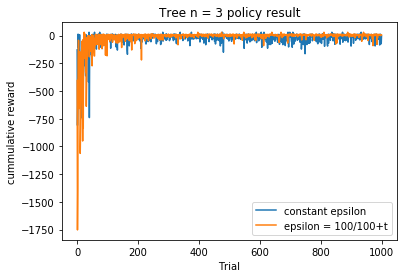

constatnt time = 1.1728923759999361
dynamic time = 1.0080051319998802


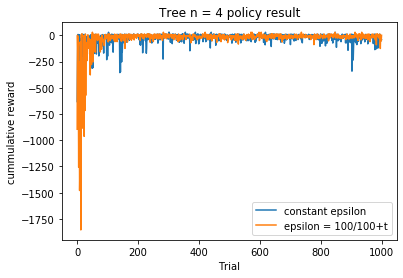

In [28]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_Tr = Agent_Nstep_Tr('6', env, 4,100,0.1,0.5,2)
t = timeit.default_timer()
agent_Tr.main_loop()
t1_Tr = timeit.default_timer() - t
print("constatnt time = "+str(t1_Tr))
agent_Tr2 = Agent_Nstep_Tr('6', env, 4,100,0.1,0,2)
t = timeit.default_timer()
agent_Tr2.main_loop()
t2_Tr = timeit.default_timer() - t
print("dynamic time = "+str(t2_Tr))
plt.plot([i for i in range(1000)],agent_Tr.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent_Tr2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Tree n = 2 policy result")
plt.legend()
plt.show()
env =  GridworldEnv()
env.reset()
#print(env.P)
agent3_Tr = Agent_Nstep_Tr('6', env, 4,100,0.1,0.5,3)
t = timeit.default_timer()
agent3_Tr.main_loop()
t1_Tr3 = timeit.default_timer() - t
print("constatnt time = "+str(t1_Tr3))
agent3_Tr2 = Agent_Nstep_Tr('6', env, 4,100,0.1,0,3)
t = timeit.default_timer()
agent3_Tr2.main_loop()
t2_Tr3 = timeit.default_timer() - t
print("dynamic time = "+str(t2_Tr3))
plt.plot([i for i in range(1000)],agent3_Tr.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent3_Tr2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Tree n = 3 policy result")
plt.legend()
plt.show()

env =  GridworldEnv()
env.reset()
#print(env.P)
agent4_Tr = Agent_Nstep_Tr('6', env, 4,100,0.1,0.5,4)
t = timeit.default_timer()
agent4_Tr.main_loop()
t1_Tr4 = timeit.default_timer() - t
print("constatnt time = "+str(t1_Tr4))
agent4_Tr2 = Agent_Nstep_Tr('6', env, 4,100,0.1,0,4)
t = timeit.default_timer()
agent4_Tr2.main_loop()
t2_Tr4 = timeit.default_timer() - t
print("dynamic time = "+str(t2_Tr4))
plt.plot([i for i in range(1000)],agent4_Tr.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent4_Tr2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Tree n = 4 policy result")
plt.legend()
plt.show()

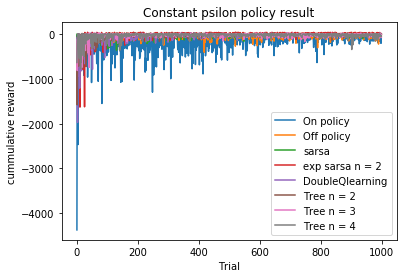

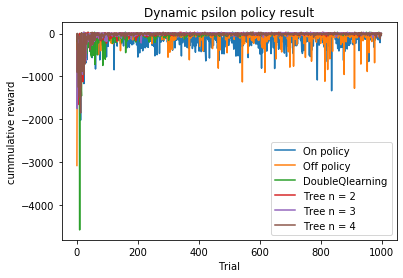

In [45]:

plt.plot([i for i in range(1000)],agent_on.R_sum, label = "On policy")
plt.plot([i for i in range(1000)],agent_of.R_sum,label="Off policy")
plt.plot([i for i in range(1000)],agent_sarsa.R_sum[0:1000], label="sarsa")
plt.plot([i for i in range(1000)],agent_sarsa_2xp.R_sum, label="exp sarsa n = 2")
plt.plot([i for i in range(1000)],agent_DQ.R_sum, label="DoubleQlearning")
plt.plot([i for i in range(1000)],agent_Tr.R_sum, label="Tree n = 2")
plt.plot([i for i in range(1000)],agent3_Tr.R_sum, label="Tree n = 3")
plt.plot([i for i in range(1000)],agent4_Tr.R_sum, label="Tree n = 4")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Constant psilon policy result")
plt.legend()
plt.show()


plt.plot([i for i in range(1000)],agent_on2.R_sum, label = "On policy")
plt.plot([i for i in range(1000)],agent_of2.R_sum, label="Off policy")
plt.plot([i for i in range(1000)],agent_DQ2.R_sum, label="DoubleQlearning")
plt.plot([i for i in range(1000)],agent_Tr2.R_sum, label="Tree n = 2")
plt.plot([i for i in range(1000)],agent3_Tr2.R_sum, label="Tree n = 3")
plt.plot([i for i in range(1000)],agent4_Tr2.R_sum, label="Tree n = 4")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("Dynamic psilon policy result")
plt.legend()
plt.show()

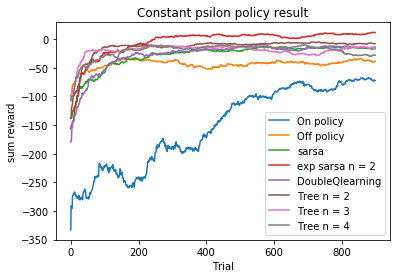

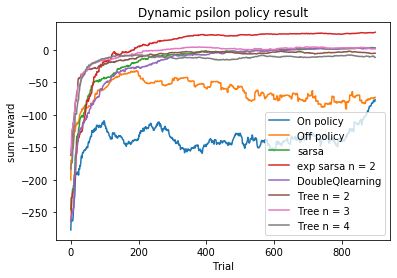

In [47]:
plt.plot([i for i in range(900)],[np.mean(agent_on.R_sum[i:i+ 100]) for i in range(900)], label = "On policy")
plt.plot([i for i in range(900)],[np.mean(agent_of.R_sum[i:i+ 100]) for i in range(900)],label="Off policy")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa.R_sum[i:i+ 100]) for i in range(900)], label="sarsa")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa_2xp.R_sum[i:i+ 100]) for i in range(900)], label="exp sarsa n = 2")
plt.plot([i for i in range(900)],[np.mean(agent_DQ.R_sum[i:i+ 100]) for i in range(900)], label="DoubleQlearning")
plt.plot([i for i in range(900)],[np.mean(agent_Tr.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 2")
plt.plot([i for i in range(900)],[np.mean(agent3_Tr.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 3")
plt.plot([i for i in range(900)],[np.mean(agent4_Tr.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 4")
plt.xlabel("Trial")
plt.ylabel("sum reward")
plt.title("Constant psilon policy result")
plt.legend()
plt.show()


plt.plot([i for i in range(900)],[np.mean(agent_on2.R_sum[i:i+ 100]) for i in range(900)], label = "On policy")
plt.plot([i for i in range(900)],[np.mean(agent_of2.R_sum[i:i+ 100]) for i in range(900)],label="Off policy")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa2.R_sum[i:i+ 100]) for i in range(900)], label="sarsa")
plt.plot([i for i in range(900)],[np.mean(agent_sarsa_2xp2.R_sum[i:i+ 100]) for i in range(900)], label="exp sarsa n = 2")
plt.plot([i for i in range(900)],[np.mean(agent_DQ2.R_sum[i:i+ 100]) for i in range(900)], label="DoubleQlearning")
plt.plot([i for i in range(900)],[np.mean(agent_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 2")
plt.plot([i for i in range(900)],[np.mean(agent3_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 3")
plt.plot([i for i in range(900)],[np.mean(agent4_Tr2.R_sum[i:i+ 100]) for i in range(900)], label="Tree n = 4")

plt.xlabel("Trial")
plt.ylabel("sum reward")
plt.title("Dynamic psilon policy result")
plt.legend()
plt.show()

